In [1]:
%reset -f

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from utils.aiwt import cjkfun, cjkfun2, z_g, CompressInterp, IncreaseInterp, adapt_CjJ4
from utils.pde import Precise, theta1_2d
from utils.tools import Draw, DrawCollocationPoint

In [3]:
# 分解级别，初始级别
J = 15
j0 = 0

# 函数区间
a = 0
b = 2

# “雷诺数”
Re = 1000

# 离散间隔
deltax = (b-a)/(2**J)

# 离散
XJ0 = np.arange(a, b+deltax, deltax).reshape(1,-1)

# V0空间
V0 = np.sin(np.pi * XJ0)

# 与邻点有关的量
M = 1
CC = 1

# 偏微分方程的时间量与时间步长 （数值解迭代参数）
t = 0.4
tao = 0.001

# 阈值
eps0 = 0.005

# 判断前后两次得到的配点是否完全相同
same = np.inf

# 画图时需要的参数
nn_dict = {1:[1,'0.01'], 400:[3,'0.4'], 600:[5,'0.6'], 800:[1,'0.8'],
           1200:[3,'1.2'], 600:[5,'1.6'], 2000:[1,'2.0'], 2400:[3,'2.4'],
           2600:[5,'2.6'], 2800:[1,'2.8'], 3000:[3,'3.0'], 3200:[5,'3.2']}

**nn = 1**

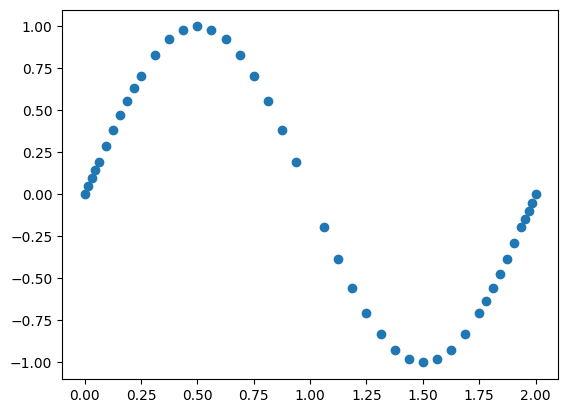

In [4]:
nn = 1

# 获取配点
cjk, cjknum, zJc, zJcnum = cjkfun(V0, J, j0, a, b, eps0)

# 保存配点位置，用于与下一次得到的配点比较
cjk0 = cjk.copy()

# 扩展了每层的配点
gjk, gjknum, gJc, gJcnum = z_g(j0, J, cjk, cjknum, zJc, zJcnum, a, b, M, CC)

# 实际位置索引得的自变量值【x的值】
XJ = a + deltax * gJc

# 压缩数据量（只留下一些有涉及到计算的值）
# 即：所有配点实际位置索引得到的自变量值对应的因变量值
V0 = CompressInterp(XJ0, V0, XJ)
plt.scatter(XJ, V0[:,0])

In [5]:
# PDE

# 得到所有层的插值算子
C = adapt_CjJ4(J, j0, gjk, gjknum, gJc, gJcnum, a, b)

# 得到所有层的插值算子的一阶导数和二阶导数
theta1d, theta2d = theta1_2d(J, j0, a, b, C, gjk, gjknum, gJc, gJcnum)

# 精细积分，得到下一个时刻的状态为V1
V1 = Precise(V0, Re, theta1d,theta2d,gJcnum,tao)

Amount of the characteristic points: 22


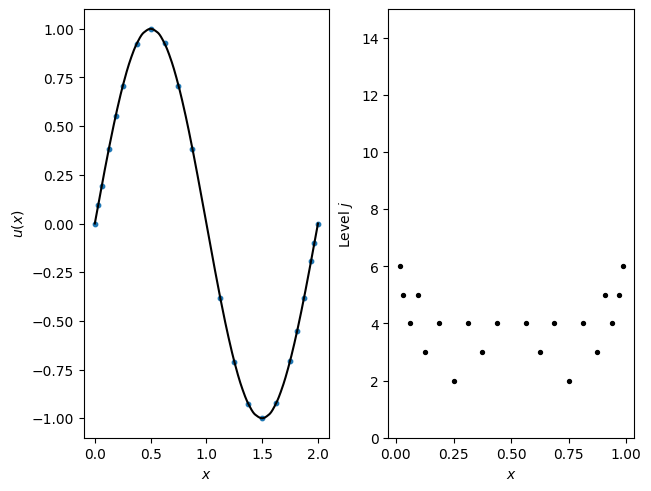

In [6]:
# 画图
fig, axs=plt.subplots(1,2,constrained_layout=True)
if nn_dict.get(nn):

    # 画图所需参数
    num, Title = nn_dict.get(nn)

    # 经上述操作得到的函数曲线，配点分布
    Draw(axs[0], XJ, V1, cjk, cjknum, zJc, a, b, j0, J)
    DrawCollocationPoint(axs[1], cjk, cjknum, a, b, j0,J)
    
    # 配点个数
    print('Amount of the characteristic points:', zJcnum)


**nn = 2**

In [7]:
nn = 2
gjk0 = gjk.copy()
gjknum0 = gjknum.copy()
gJc0 = gJc.copy()
gJcnum0 = gJcnum
XJ0 = XJ.copy()
V0 = V1.copy().T

In [8]:
cjk, cjknum, zJc, zJcnum = cjkfun2(V1, J, C, j0, gjk, gjknum, gJcnum, eps0)

In [9]:
# 判断前后两次得到的配配点是否完全相同
same = 0
eq = True
row1, col1 = len(cjk), len(max(cjk, key=len))
row0, col0 = len(cjk0), len(max(cjk0, key=len))
if row1 == row0 and col0 == col1:
    for i in range(row1):
        if not np.array_equal(cjk[i], cjk0[i]):
            eq = False
            break
    if eq:
        same = 1

# 用于与下一次得到的配点比较 
cjk0 = cjk.copy()

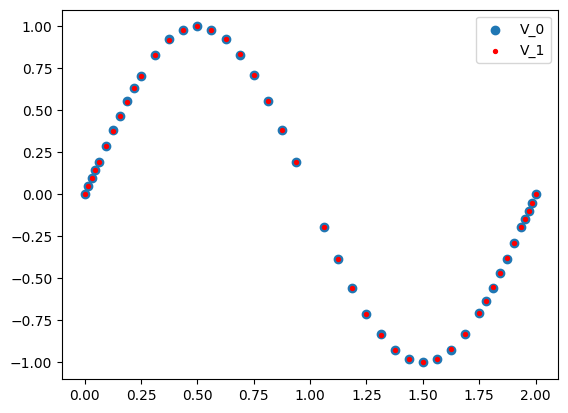

In [10]:
# 得same=1时操作：
if same == 1:
    
    V0 = V1
    V1 = Precise(V0, Re, theta1d,theta2d,gJcnum,tao)

    # vs
    plt.scatter(XJ, V0[:,0],label='V_0')
    plt.scatter(XJ, V1[:,0], s=8, c='r', label='V_1')
    plt.legend()

In [11]:
# 得same=0时操作：
if same == 0:

    # 如果前后两次得到的配点不一样，需要加入邻点
    gjk, gjknum, gJc, gJcnum = z_g(j0, J, cjk, cjknum, zJc, zJcnum, a, b, M, CC)
    XJ = a + deltax * gJc

    # 原本压缩数据量（只保留计算需要用到的点）得到的V0 需再加入
    V0 = IncreaseInterp(XJ0, V0, XJ, J, j0, gjk0, gjknum0, 
                        gJc0, gJcnum0, a, b, C)
    
    # PDE
    # 重新计算插值算子及其导数，精细积分得到下一个时刻的状态V1
    C = adapt_CjJ4(J, j0, gjk, gjknum, gJc, gJcnum, a, b)
    theta1d, theta2d = theta1_2d(J, j0, a, b, C, gjk, gjknum, gJc, gJcnum)
    V1 = Precise(V0, Re, theta1d,theta2d,gJcnum,tao)
    
    # vs
    plt.scatter(XJ, V0[:,0],label='V_0')
    plt.scatter(XJ, V1[:,0], s=8, c='r', label='V_1')
    plt.legend()

# 完整代码

In [12]:
%reset -f

In [13]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from utils.aiwt import cjkfun, cjkfun2, z_g, CompressInterp, IncreaseInterp, adapt_CjJ4
from utils.pde import Precise, theta1_2d
from utils.tools import Draw, DrawCollocationPoint

Amount of the characteristic points:
22
Amount of the characteristic points:
78


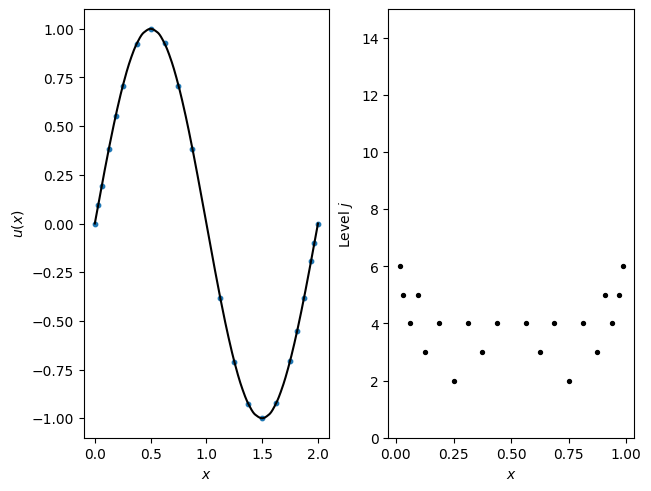

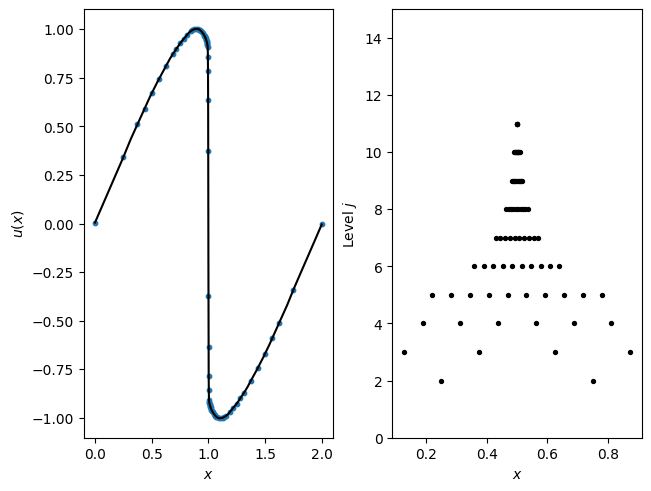

In [14]:
J = 15
j0 = 0
a = 0
b = 2
Re = 1000
deltax = (b-a)/(2**J)
XJ0 = np.arange(a, b+deltax, deltax).reshape(1,-1)
V0 = np.sin(np.pi * XJ0)
M = 1
CC = 1
t = 0.4
tao = 0.001
eps0 = 0.005
same = np.inf
nn_dict = {1:[1,'0.01'], 400:[3,'0.4'], 600:[5,'0.6'], 800:[1,'0.8'],
           1200:[3,'1.2'], 600:[5,'1.6'], 2000:[1,'2.0'], 2400:[3,'2.4'],
           2600:[5,'2.6'], 2800:[1,'2.8'], 3000:[3,'3.0'], 3200:[5,'3.2']}

for nn in range(1, round(t / tao) + 1):  # 迭代
    if nn == 1:
        cjk, cjknum, zJc, zJcnum = cjkfun(V0, J, j0, a, b, eps0)
    elif nn > 1:
        gjk0 = gjk.copy()
        gjknum0 = gjknum.copy()
        gJc0 = gJc.copy()
        gJcnum0 = gJcnum
        XJ0 = XJ.copy()
        V0 = V1.copy().T
        cjk, cjknum, zJc, zJcnum = cjkfun2(V1, J, C, j0, gjk, gjknum, gJcnum, eps0)

        same = 0
        eq = True
        row1, col1 = len(cjk), len(max(cjk, key=len))
        row0, col0 = len(cjk0), len(max(cjk0, key=len))
        if row1 == row0 and col0 == col1:
            for i in range(row1):
                if not np.array_equal(cjk[i], cjk0[i]):
                    eq = False
                    break
            if eq:
                same = 1
    cjk0 = cjk.copy()

    if nn == 1 or same == 0:
        gjk, gjknum, gJc, gJcnum = z_g(j0, J, cjk, cjknum, zJc, zJcnum, a, b, M, CC)
        XJ = a + deltax * gJc
        if nn == 1:
            V0 = CompressInterp(XJ0, V0, XJ)
        else:
            V0 = IncreaseInterp(XJ0, V0, XJ, J, j0, gjk0, gjknum0, 
                                gJc0, gJcnum0, a, b, C)
        C = adapt_CjJ4(J, j0, gjk, gjknum, gJc, gJcnum, a, b)
        theta1d, theta2d = theta1_2d(J, j0, a, b, C, gjk, gjknum, gJc, gJcnum)
    else:
        V0 = V1
    V1 = Precise(V0, Re, theta1d,theta2d,gJcnum,tao)
    if nn_dict.get(nn):
        fig, axs=plt.subplots(1,2,constrained_layout=True)
        num, Title = nn_dict.get(nn)
        Draw(axs[0], XJ, V1, cjk, cjknum, zJc, a, b, j0, J)
        DrawCollocationPoint(axs[1], cjk, cjknum, a, b, j0,J)
        print('Amount of the characteristic points:')
        print(zJcnum)

In [15]:
# UE = pdepeBurgers(Re, J, a, b, 0, t, gJc)

# error = UE - V1.T
# plt.figure()
# plt.plot(XJ,abs(error),'k-')
# plt.xlabel('\itx')
# plt.ylabel('Error')

# e1 = max(abs(error))
# e2 = np.norm(error, 2) / gJcnum